Let's load up our data and do a little feature engineering; our data is mostly numeric, and we want to convert the target variable to a boolean.

In [1]:
import pandas as pd

COLUMNS = ['AGE', 'GENDER', 'SMOKING', 'FINGER_DISCOLORATION', 'MENTAL_STRESS', 'EXPOSURE_TO_POLLUTION', 'LONG_TERM_ILLNESS', 'ENERGY_LEVEL',
       'IMMUNE_WEAKNESS', 'BREATHING_ISSUE', 'ALCOHOL_CONSUMPTION', 'THROAT_DISCOMFORT', 'OXYGEN_SATURATION', 'CHEST_TIGHTNESS',
       'FAMILY_HISTORY', 'SMOKING_FAMILY_HISTORY', 'STRESS_IMMUNE',]
DATA = '/kaggle/input/lung-cancer-prediction-dataset/Lung Cancer Dataset.csv'
RANDOM_STATE = 2025
TARGET = 'PULMONARY_DISEASE'
df = pd.read_csv(filepath_or_buffer=DATA)
df[TARGET] = df[TARGET] == 'YES'
df.head()

,AGE,GENDER,SMOKING,FINGER_DISCOLORATION,MENTAL_STRESS,EXPOSURE_TO_POLLUTION,LONG_TERM_ILLNESS,ENERGY_LEVEL,IMMUNE_WEAKNESS,BREATHING_ISSUE,ALCOHOL_CONSUMPTION,THROAT_DISCOMFORT,OXYGEN_SATURATION,CHEST_TIGHTNESS,FAMILY_HISTORY,SMOKING_FAMILY_HISTORY,STRESS_IMMUNE,PULMONARY_DISEASE
0,68,1,1,1,1,1,0,57.831178,0,0,1,1,95.977287,1,0,0,0,False
1,81,1,1,0,0,1,1,47.694835,1,1,0,1,97.184483,0,0,0,0,True
2,58,1,1,0,0,0,0,59.577435,0,1,1,0,94.974939,0,0,0,0,False
3,44,0,1,0,1,1,0,59.785767,0,1,0,1,95.187900,0,0,0,0,True
4,72,0,1,1,1,1,1,59.733941,0,1,0,1,93.503008,0,0,0,0,True


Let's make an exploratory plot and see if our data has any trends in it.

In [2]:
from sklearn.manifold import TSNE

reducer = TSNE(random_state=RANDOM_STATE)
plot_df = pd.DataFrame(columns=['x', 'y'], data=reducer.fit_transform(X=df[COLUMNS]))
plot_df[TARGET] = df[TARGET].tolist()

In [3]:
from plotly import express
from plotly import io

io.renderers.default = 'iframe'
express.scatter(data_frame=plot_df, x='x', y='y', color=TARGET)

This is the sort of plot we often see when dealing with synthetic data. Let's explore some of the variables.

In [4]:
express.scatter(data_frame=df, x='OXYGEN_SATURATION', y='ENERGY_LEVEL', facet_col=TARGET, color='GENDER')

This data looks very random. We would expect there to be some correlation between o2 sats and energy level. Is there?

In [5]:
df[['OXYGEN_SATURATION', 'ENERGY_LEVEL']].corr()

,OXYGEN_SATURATION,ENERGY_LEVEL
OXYGEN_SATURATION,1.000000,0.008761
ENERGY_LEVEL,0.008761,1.000000


There's essentially no correlation. Let's look at all of the numerical data  and see if any of our variables are correlated.

<Axes: >

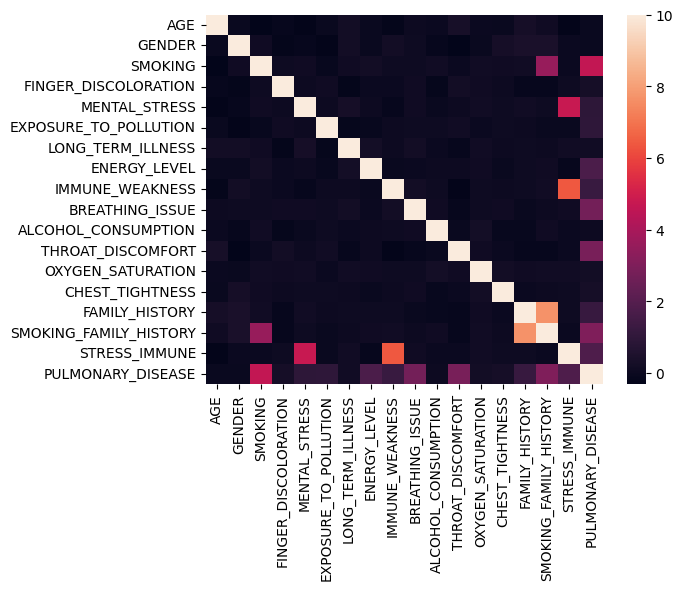

In [6]:
from seaborn import heatmap
heatmap(data=10 * df.corr(numeric_only=True),)

This is very odd; some of our variables are correlated with the target variable, but almost none of them are correlated with each other. Let's build a classifier and see what happens.

In [7]:
df[TARGET].value_counts().to_frame().T

PULMONARY_DISEASE,False,True
count,2963,2037


Our target variable is unbalanced about three to two. Let's rebalance.

In [8]:
sample_df = pd.concat(axis='index', objs=[df[df[TARGET]].sample(n=2000, random_state=RANDOM_STATE), df[~df[TARGET]].sample(n=2000, random_state=RANDOM_STATE)]).sort_index()
sample_df[TARGET].value_counts().to_frame().T

PULMONARY_DISEASE,False,True
count,2000,2000


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[COLUMNS], df[TARGET], test_size=0.4, random_state=2024, stratify=df[TARGET])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 658 iterations
accuracy: 0.8880
f1: 0.8883
              precision    recall  f1-score   support

       False       0.91      0.89      0.90      1185
        True       0.85      0.88      0.86       815

    accuracy                           0.89      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.89      0.89      0.89      2000



That's really surprising. Let's look at our feature importances.

In [10]:
express.bar(x=COLUMNS, y=logreg.coef_[0])

Not surprisingly, smoking is an important feature, as are breathing issues, throat issues, stress immunity, and a family history of smoking.